In [13]:
#######################
### LOAD IN MODULES ###
#######################

import cv2 # to install on mac: pip install opencv-python
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
from scipy.spatial import procrustes # for Procrustes analysis
from scipy.spatial import ConvexHull # for convex hull
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import matplotlib.pyplot as plt # for plotting
import numpy as np # for using arrays
import math # for mathematical operations
import pandas as pd # for using pandas dataframes
import seaborn as sns # for plotting in seaborn
from matplotlib.colors import LogNorm
from sklearn.model_selection import StratifiedKFold
import itertools # for pairwise combinations
import scipy.stats as stats # for kruskal wallis test
import statsmodels.stats.multitest as multitest # multiple test adjustment

In [14]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean

def polygon_perimeter(vertices):
    # Ensure the polygon is closed: append the first point to the end
    closed_vertices = np.vstack([vertices, vertices[0]])
    # Compute pairwise distances
    diffs = np.diff(closed_vertices, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)
    return segment_lengths.sum()


# Read in data

In [52]:
########################
### READ IN METADATA ###
########################

mdata = pd.read_csv("./metadata_v5.csv") # read in csv

mdata.head() # head data to check

# drop any row with NaN
mdata = mdata.dropna().reset_index(drop=True)

# drop rows with "r" for node value
#mdata = mdata[mdata['node'] != "r"].reset_index(drop=True)

# replace species mis-spellings
mdata['species'] = mdata['species'].replace({'apalacnicolensis': 'apalachicolensis'}) 
mdata['species'] = mdata['species'].replace({'canybi': 'canbyi'}) 

# make sure variables are floats
#mdata["node"] = mdata["node"].astype(float)
#mdata["count"] = mdata["count"].astype(float)
mdata['px_cm'] = mdata['px_cm'].astype(float)


In [53]:
#######################################
### MAKE A LIST OF IMAGE FILE NAMES ###
#######################################

data_dir = "./binary_leaves_v5/" # set data directory

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

if '.DS_Store' in file_names:
    file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

file_names # check list of file names

['LAMOEWC23246-1_10_13.tif',
 'LAMOEWC23246-1_11_13.tif',
 'LAMOEWC23246-1_12_13.tif',
 'LAMOEWC23246-1_13_13.tif',
 'LAMOEWC23246-1_1_13.tif',
 'LAMOEWC23246-1_2_13.tif',
 'LAMOEWC23246-1_3_13.tif',
 'LAMOEWC23246-1_4_13.tif',
 'LAMOEWC23246-1_5_13.tif',
 'LAMOEWC23246-1_6_13.tif',
 'LAMOEWC23246-1_7_13.tif',
 'LAMOEWC23246-1_8_13.tif',
 'LAMOEWC23246-1_9_13.tif',
 'LAMOEWC23246-2_1_5.tif',
 'LAMOEWC23246-2_2_5.tif',
 'LAMOEWC23246-2_3_5.tif',
 'LAMOEWC23246-2_4_5.tif',
 'LAMOEWC23246-2_5_5.tif',
 'LAPALBS17132-1_10_28.tif',
 'LAPALBS17132-1_11_28.tif',
 'LAPALBS17132-1_12_28.tif',
 'LAPALBS17132-1_13_28.tif',
 'LAPALBS17132-1_14_28.tif',
 'LAPALBS17132-1_15_28.tif',
 'LAPALBS17132-1_16_28.tif',
 'LAPALBS17132-1_17_28.tif',
 'LAPALBS17132-1_18_28.tif',
 'LAPALBS17132-1_19_28.tif',
 'LAPALBS17132-1_1_28.tif',
 'LAPALBS17132-1_20_28.tif',
 'LAPALBS17132-1_21_28.tif',
 'LAPALBS17132-1_22_28.tif',
 'LAPALBS17132-1_23_28.tif',
 'LAPALBS17132-1_24_28.tif',
 'LAPALBS17132-1_25_28.tif',
 'LAP

# Process and landmark data

- Read in image in grayscale
- Select the contour of the largest object (the leaf)
- Interpolate with a high resolution of pseudo-landmarks
- Find the base and tip index point on the high resolution contour
- Reset the base index to zero
- Interpolate each side with desired number of equidistant pseudo-landmarks
- Rotate leaves and scale to centimeters
- Save pseudo-landmarks scaled to centimeters in an array

PARAMETERS AND INDEXING:
- `high_res_pts` is an arbitrarily high number of points to initially interpolate
- `res` is the desired number of points to interpolate on each side of the leaf
- The total number of pseudo-landmarks will be `2*res - 1`
- The base index will be `0`
- The tip index will be `res-1`
- The returned leaves in `cm_arr` are scaled in size to centimeters

First, find excluded and missing leaves where the metadata file name is not found in the binary files

In [54]:
exclude_leaves = [] # leaf names to exclude
exclude_inds = [] # indices of leaf names to exclude

missing_leaves = [] # metadata leaf name not in files
missing_inds = [] # indices of metadata leaf names not in files

# for each leaf . . .
for lf in range(len(mdata)):
    if mdata["include"][lf]=="N":
        exclude_leaves.append(mdata["file"][lf])
        exclude_inds.append(lf)

    elif mdata["file"][lf]+".tif" not in file_names:
        missing_leaves.append(mdata["file"][lf])
        missing_inds.append(lf)
        
print("There are", len(exclude_inds), "excluded leaves")
print("There are", len(missing_inds), "missing leaves")

# save the missing leaves
file_path = "missing_leaves.txt"
with open(file_path, 'w') as file:
    for item in missing_leaves:
        file.write(item + '\n')


There are 939 excluded leaves
There are 1 missing leaves


In [55]:
# which image files not in metadata?
# AFTER METADATA PROCESSED

meta_data_files = mdata["file"].to_list()
missing_metadata_files = []
for file in file_names:
    if file[:-4] not in meta_data_files:
        missing_metadata_files.append(file)

# save the missing leaves
file_path = "missing_leaves_in_metadata_AFTER_PROCESSING.txt"
with open(file_path, 'w') as file:
    for item in missing_metadata_files:
        file.write(item + '\n')

len(missing_metadata_files)


8

**NOTE: REMEMBER TO UNCOMMENT IF NEEDED**

In [56]:
# which image files not in metadata?
# BEFORE METADATA PROCESSED

#mdata = pd.read_csv("./metadata_v5.csv") # read in csv

meta_data_files = mdata["file"].to_list()
missing_metadata_files = []
for file in file_names:
    if file[:-4] not in meta_data_files:
        missing_metadata_files.append(file)

# save the missing leaves
file_path = "missing_leaves_in_metadata_BEFORE_PROCESSING.txt"
with open(file_path, 'w') as file:
    for item in missing_metadata_files:
        file.write(item + '\n')

len(missing_metadata_files)

8

Next, remove the indices of excluded or missing leaves before analysis

**NOTE: EXCLUDE INDICES ARE COMMENTED OUT**

In [57]:
remove_inds = missing_inds #+ exclude_inds # create list of indices to remove from mdata

mdata = mdata.drop(remove_inds, axis=0)

mdata = mdata.reset_index(drop=True) # Reset the index

print(len(mdata), "leaves will be analyzed") # how many leaves are being analyzed?

4086 leaves will be analyzed


In [58]:
######################
### SET PARAMETERS ###
######################

# the number of equidistant points to create
# an initial high resolution outline of the leaf
high_res_pts = 10000

# the ultimate number of equidistant points on each side of the leaf
# (-1 for the tip)
# the leaf will have res*2-1 pseudo-landmarks
#################
#################
#################
res = 50 ########
#################
#################
#################

# an array to store pseudo-landmarks
cm_arr = np.zeros((len(mdata),(res*2)-1,2))

# for each leaf . . .
for lf in range(len(mdata)):

    ###############################
    ### READ IN GRAYSCALE IMAGE ###
    ###############################

    curr_image = mdata["file"][lf]+".tif" # select the current image

    #if mdata["include"][lf]=="N":
    #    continue

    print(lf, curr_image) # print each leaf in case there are problems later

    # read in image
    # convert to grayscale
    # invert the binary
    img = cv2.bitwise_not(cv2.cvtColor(cv2.imread(data_dir + curr_image),cv2.COLOR_BGR2GRAY))

    # find contours of binary objects
    contours, hierarchy = cv2.findContours(img,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ##############################
    ### SELECT LARGEST CONTOUR ###
    ##############################

    # ideally there is only one leaf in the image
    # in the case there are smaller objects
    # this code selects the largest object (the leaf)
    # if there is one and only one object in the image
    # then the following code is not necessary

    x_conts = [] # list of lists of contour x vals
    y_conts = [] # list of lists of contour y vals
    areas_conts = [] # list of bounding box areas of contours
    for c in contours: # for each contour
        x_vals = [] # store x vals for current contour 
        y_vals = [] # store y vals for current contour
        for i in range(len(c)): # for each point in current contour
            x_vals.append(c[i][0][0]) # isolate x val
            y_vals.append(c[i][0][1]) # isolate y val
        area = (max(x_vals) - min(x_vals))*(max(y_vals) - min(y_vals)) # calculate bounding box area of contour
        x_conts.append(x_vals) # append the current contour x vals
        y_conts.append(y_vals) # append the current contour y vals
        areas_conts.append(area) # append the current contour bounding box areas

    area_inds = np.flip(np.argsort(areas_conts)) # get indices to sort contours by area
    sorted_x_conts = np.array(x_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, x vals
    sorted_y_conts = np.array(y_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, y vals

    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaf to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(np.array(sorted_x_conts[0], dtype=np.float32), 
                                           np.array(sorted_y_conts[0], dtype=np.float32), high_res_pts)

    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    # get the base and tip landmark point values
    base_pt = np.array((mdata["base_x"][lf], mdata["base_y"][lf]))
    tip_pt = np.array((mdata["tip_x"][lf], mdata["tip_y"][lf]))

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)

    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaf coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))

    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaf
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))

    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))
    
    # calculate leaf area in pixels^2
    lf_area_px2 = poly_area(rot_pts[:,0], rot_pts[:,1])
    
    # get px_cm
    px_cm = mdata["px_cm"][lf]

    # scale leaf into cm
    cm_lf = rot_pts/(px_cm)
    
    # store the leaf scaled into cm into the cm_arr
    cm_arr[lf,:,:] = cm_lf


0 LAMOEWC23246-1_1_13.tif
1 LAMOEWC23246-1_10_13.tif
2 LAMOEWC23246-1_11_13.tif
3 LAMOEWC23246-1_12_13.tif
4 LAMOEWC23246-1_13_13.tif
5 LAMOEWC23246-1_2_13.tif
6 LAMOEWC23246-1_3_13.tif
7 LAMOEWC23246-1_4_13.tif
8 LAMOEWC23246-1_5_13.tif
9 LAMOEWC23246-1_6_13.tif
10 LAMOEWC23246-1_7_13.tif
11 LAMOEWC23246-1_8_13.tif
12 LAMOEWC23246-1_9_13.tif
13 LAMOEWC23246-2_1_5.tif
14 LAMOEWC23246-2_2_5.tif
15 LAMOEWC23246-2_3_5.tif
16 LAMOEWC23246-2_4_5.tif
17 LAMOEWC23246-2_5_5.tif
18 LAPALBS17132-1_1_28.tif
19 LAPALBS17132-1_10_28.tif
20 LAPALBS17132-1_11_28.tif
21 LAPALBS17132-1_12_28.tif
22 LAPALBS17132-1_13_28.tif
23 LAPALBS17132-1_14_28.tif
24 LAPALBS17132-1_15_28.tif
25 LAPALBS17132-1_16_28.tif
26 LAPALBS17132-1_17_28.tif
27 LAPALBS17132-1_18_28.tif
28 LAPALBS17132-1_19_28.tif
29 LAPALBS17132-1_2_28.tif
30 LAPALBS17132-1_20_28.tif
31 LAPALBS17132-1_21_28.tif
32 LAPALBS17132-1_22_28.tif
33 LAPALBS17132-1_23_28.tif
34 LAPALBS17132-1_24_28.tif
35 LAPALBS17132-1_25_28.tif
36 LAPALBS17132-1_26_28

/var/folders/74/p7lyl9yx35b6wh5_7x3ply4r0000gq/T/ipykernel_91859/1676128482.py:39: RuntimeWarning: invalid value encountered in divide
  distance = distance/distance[-1]


116 LAPALMJ21173-2_5_17.tif
117 LAPALMJ21173-2_6_17.tif
118 LAPALMJ21173-2_7_17.tif
119 LAPALMJ21173-2_8_17.tif
120 LAPALMJ21173-2_9_17.tif
121 LAPALMJ21173-3_1_9.tif
122 LAPALMJ21173-3_2_9.tif
123 LAPALMJ21173-3_3_9.tif
124 LAPALMJ21173-3_4_9.tif
125 LAPALMJ21173-3_5_9.tif
126 LAPALMJ21173-3_6_9.tif
127 LAPALMJ21173-3_7_9.tif
128 LAPALMJ21173-3_8_9.tif
129 LAPALMJ21173-3_9_9.tif
130 LAPALMJ21173-4_1_11.tif
131 LAPALMJ21173-4_10_11.tif
132 LAPALMJ21173-4_11_11.tif
133 LAPALMJ21173-4_2_11.tif
134 LAPALMJ21173-4_3_11.tif
135 LAPALMJ21173-4_4_11.tif
136 LAPALMJ21173-4_5_11.tif
137 LAPALMJ21173-4_6_11.tif
138 LAPALMJ21173-4_7_11.tif
139 LAPALMJ21173-4_8_11.tif
140 LAPALMJ21173-4_9_11.tif
141 LAPPEAC21008-1_1_5.tif
142 LAPPEAC21008-1_2_5.tif
143 LAPPEAC21008-1_3_5.tif
144 LAPPEAC21008-1_4_5.tif
145 LAPPEAC21008-1_5_5.tif
146 LAPPEAC21008-2_1_13.tif
147 LAPPEAC21008-2_10_13.tif
148 LAPPEAC21008-2_11_13.tif
149 LAPPEAC21008-2_12_13.tif
150 LAPPEAC21008-2_13_13.tif
151 LAPPEAC21008-2_2_13.tif


# Check by plotting random leaves

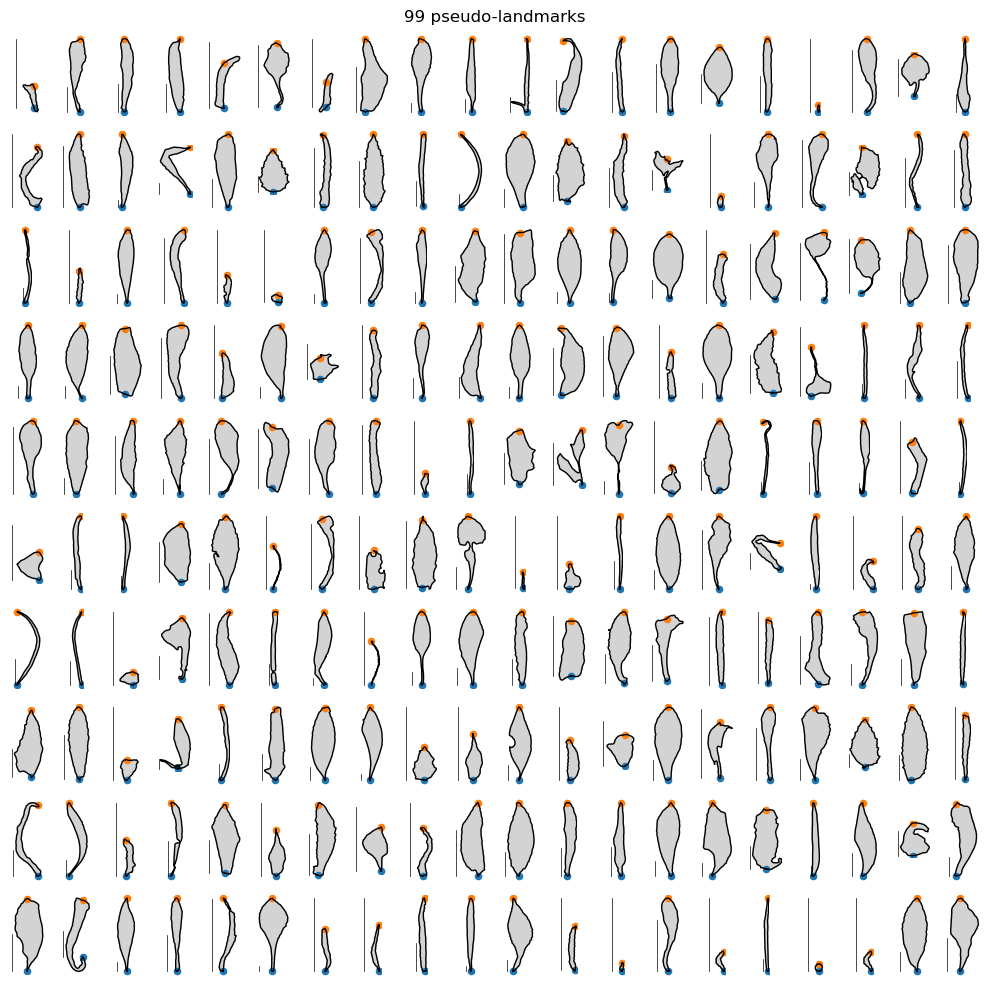

In [60]:
# Plot random leaves and check that it is working

plt.figure(figsize=(10,10)) # set figure size

rand_indices = np.random.randint(0,len(cm_arr),200) # generate random indices of leaves

plot_num = 1 # plot counter number

for i in rand_indices:
    
    plt.subplot(10,20,plot_num) # subplot number
    
    plt.plot(cm_arr[i,:,0], cm_arr[i,:,1], c="k", lw=1) # outline
    plt.fill(cm_arr[i,:,0], cm_arr[i,:,1], c="lightgray", lw=1) # fill
    
    plt.plot([min(cm_arr[i,:,0])-0.1,min(cm_arr[i,:,0])-0.1],
            [cm_arr[i,0,1], cm_arr[i,0,1]+1], c="k", lw=0.5) # cm scale
    
    #plt.scatter(cm_arr[i,:,0], cm_arr[i,:,1], c="k", s=0.1) # points
    plt.scatter(cm_arr[i,0,0], cm_arr[i,0,1], s=20) # base
    plt.scatter(cm_arr[i,res-1,0], cm_arr[i,res-1,1], s=20) # tip
    
    #plt.title(mdata["species"][i], fontsize=6)
    
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
    plot_num += 1
    
plt.suptitle(str(res*2-1) + " pseudo-landmarks")
plt.tight_layout()

# Analyze leaf dimensions

Using placed pseudo-landmarks representing leaves that are rotated upwards and scaled in centimeters from `cm_arr`, calculate the following:

- `width`: difference in centimeters between minimum and maximum x values in an oriented leaf
- `length`: difference in centimeters between minimum and maximum y values in an oriented leaf
- `area`: area of the leaf in centimeters squared
- `solidity`: the ratio of area to convex hull area

Data is stored in the `mdata` dataframe.

In [62]:
# lists to store variables
width_list = []
length_list = []
area_list = []
peri_list = []
solidity_list = []
circ_list = []

# for each leaf . . .
for lf in range(len(cm_arr)):
    
    # for calculating dimensions, we need non-scaled leaves in centimeters
    curr_lf = cm_arr[lf,:,:] # select current leaf
    
    ### CALCULATE DIMENSIONS ###
    width = np.max(curr_lf[:,0])-np.min(curr_lf[:,0]) # calculate width
    length = np.max(curr_lf[:,1])-np.min(curr_lf[:,1]) # calculate length
    area = poly_area(curr_lf[:,0],curr_lf[:,1]) # calcualte area
    
    ### CALCULATE SOLIDITY ###
    hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
    vertices = hull.vertices # isolate vertex indices of convex hull
    convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
    solidity = area / convex_area # calculate solidity

    ### CALCULATE CIRCULARITY ###
    peri = polygon_perimeter(curr_lf) # calculate perimeter
    circ = (4*(math.pi)*area)/(peri)**2

    # store data in lists
    width_list.append(width)
    length_list.append(length)
    area_list.append(area)
    peri_list.append(peri)
    solidity_list.append(solidity)
    circ_list.append(circ)
  
# add data to the mdata dataframe
mdata["width"] = width_list
mdata["length"] = length_list
mdata["area"] = area_list
mdata["perimeter"] = peri_list
mdata["solidity"] = solidity_list
mdata["circularity"] = circ_list
#mdata["rel_node"] = mdata["node"]/mdata["count"]

mdata.to_csv('lobelia_dimensions.csv', index=False)


# Dimensions and allometric models

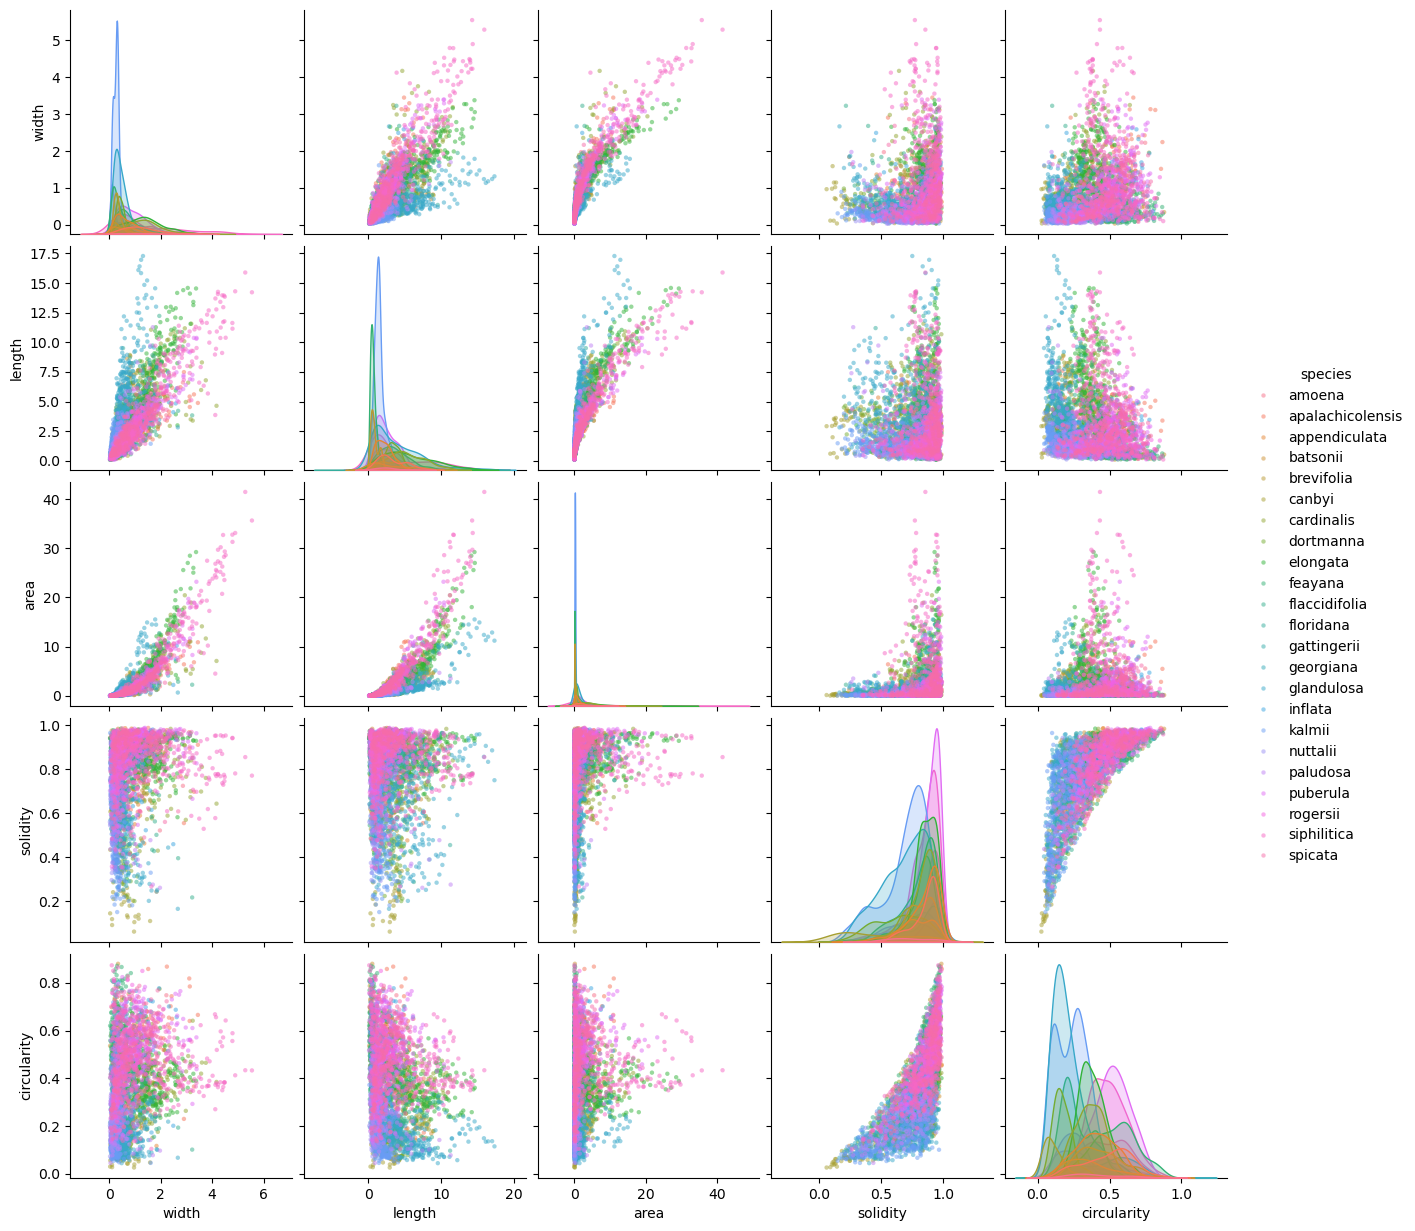

In [63]:
sns.pairplot(mdata,
             x_vars=["width", "length", "area","solidity","circularity"],
             y_vars=["width", "length", "area","solidity","circularity"],
             hue="species",
             plot_kws={"s": 10, "alpha":0.5, "lw":0}
            )


Check how linear and represented each species is before making allometric models

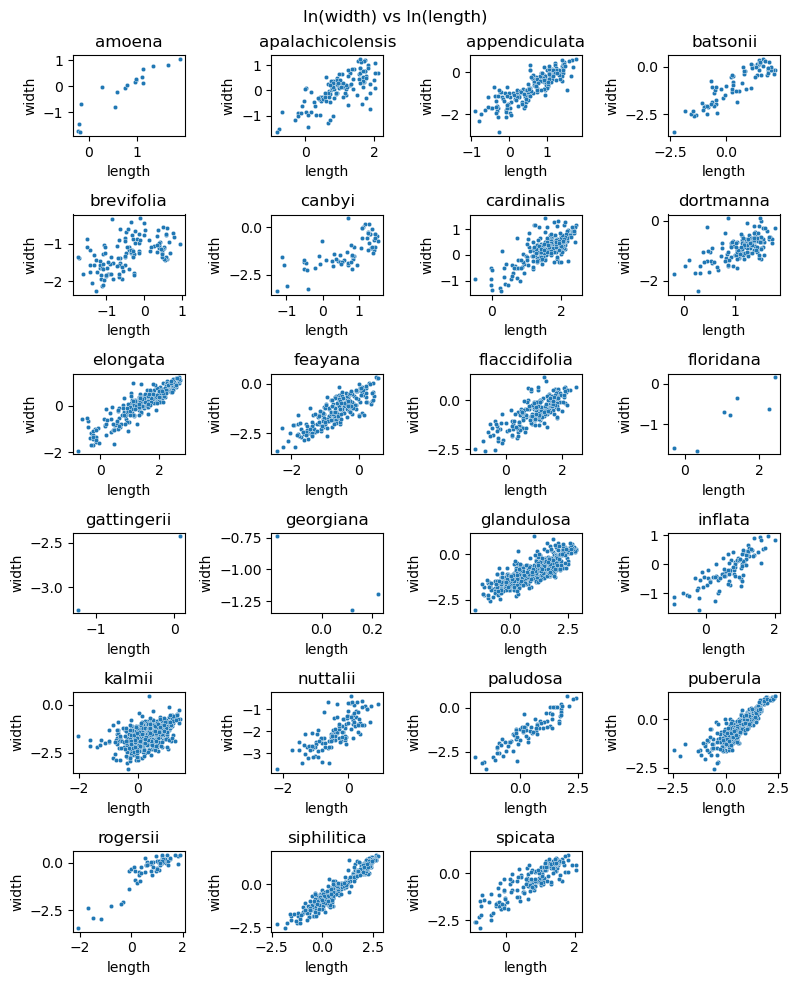

In [64]:
plt.figure(figsize=(8,10))

count = 1 # set a counter
for spe in mdata["species"].unique(): # for each species
    curr_spe = mdata[mdata["species"]==spe] # get current species

    plt.subplot(6,4,count)
    sns.scatterplot(x=np.log(curr_spe["length"]), y=np.log(curr_spe["width"]), s=10)
    plt.title(spe)
    count+=1

plt.suptitle("ln(width) vs ln(length)")
plt.tight_layout()

Create linear allometric models

In [65]:
spes = mdata["species"].unique() # get list of species

coef_list = []
func_list = []
xvals_list = []

for i in range(len(spes)):

    curr_spe = spes[i]

    coefs = np.polyfit(np.log(mdata["width"][mdata["species"]==curr_spe]),
                       np.log(mdata["length"][mdata["species"]==curr_spe]),
                      1)
    func = np.poly1d(coefs)
    xvals = np.linspace(np.log(np.min(mdata["width"][mdata["species"]==curr_spe])),
                             np.log(np.max(mdata["width"][mdata["species"]==curr_spe])), 100)

    coef_list.append(coefs)
    func_list.append(func)
    xvals_list.append(xvals)

Plot all allometric models

Text(0, 0.5, 'ln length, cm')

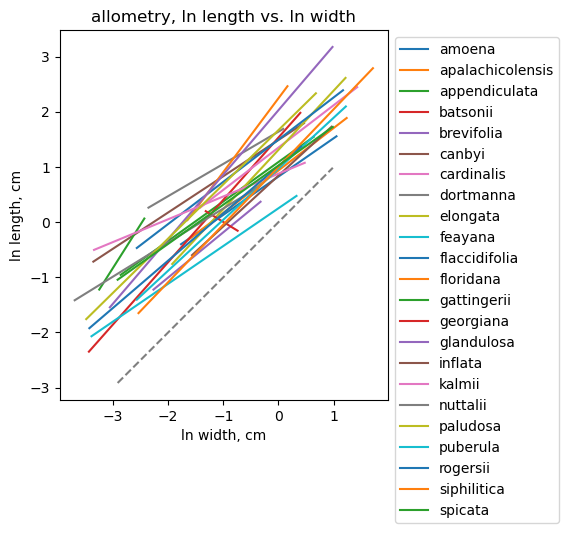

In [66]:
for i in range(len(spes)):

    curr_func = func_list[i]

    # plot allometric lines
    plt.plot(xvals_list[i], curr_func(xvals_list[i]), label=spes[i])

# plot one-to-one line
plt.plot(xvals, xvals, c="gray", linestyle="dashed")

plt.legend(bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal") # equal aspect ratio
plt.title("allometry, ln length vs. ln width") # title
plt.xlabel("ln width, cm") # x axis title
plt.ylabel("ln length, cm") # y axis title

Only plot models for those species with sufficient counts

Text(0, 0.5, 'ln length, cm')

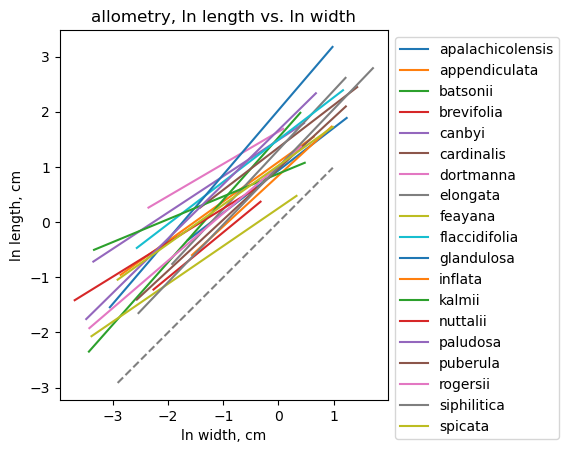

In [67]:
spe_counts = [] # a list of counts of species
for spe in spes: # for each species
    spe_counts.append(len(mdata[mdata["species"]==spe])) # get the count

thresh = 20 # set threshold count to plot

for i in range(len(spes)):
    curr_func = func_list[i]
    if spe_counts[i]>=20:
        # plot allometric lines
        plt.plot(xvals_list[i], curr_func(xvals_list[i]), label=spes[i])
    else:
        continue

# plot one-to-one line
plt.plot(xvals, xvals, c="gray", linestyle="dashed")

plt.legend(bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal") # equal aspect ratio
plt.title("allometry, ln length vs. ln width") # title
plt.xlabel("ln width, cm") # x axis title
plt.ylabel("ln length, cm") # y axis title

# Procrustes analysis

Perform a Procrustes analysis to translate, scale, and rotate leaf shapes

- Select number of pseudo-landmarks and dimensions
- Calculate the GPA mean leaf shape using the `gpa_mean` function
- Align all leaves to the GPA mean
- Store Procrustes super-imposed leaves in an array, `proc_arr`
- Calculate a PCA for all possible axes and their variance (the number of leaves)
- Calculate a PCA for just the axes needed for reconstruction of eigenleaves for morphospace (probably 2)

In [69]:
landmark_num = (res*2)-1 # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(cm_arr, landmark_num, dim_num)

################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(cm_arr)) 

for i in range(len(cm_arr)):
    s1, s2, distance = procrustes(mean_shape, cm_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

# Visualize mean leaf and allometry model together

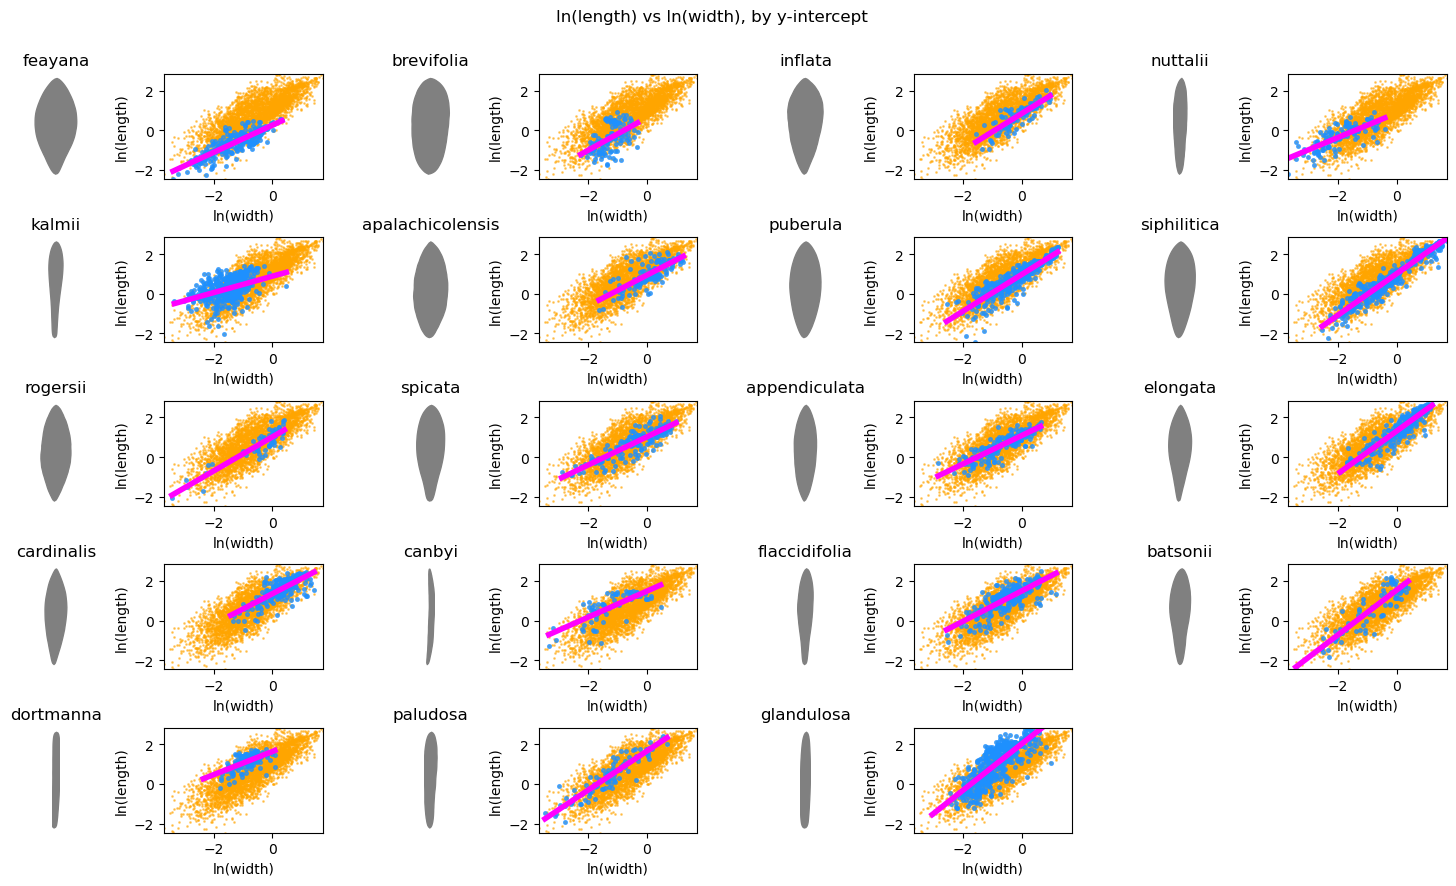

In [84]:
# get indices of species in order by slope
slope_vals = np.array(coef_list)[:,0]
slope_inds = np.argsort(slope_vals)
# get indices of species in order by intercept
intercept_vals = np.array(coef_list)[:,1]
intercept_inds = np.argsort(intercept_vals)

# get overall x and y value min and max for comparison in plotting
xmin = np.min(np.log(mdata["width"]))
xmax = np.max(np.log(mdata["width"]))
ymin = np.min(np.log(mdata["length"]))
ymax = np.max(np.log(mdata["length"]))

plt.figure(figsize=(10*1.5,6*1.5))

count=1
for i in intercept_inds:
    if spe_counts[i]<thresh: # if under threshold number of samples, continue
        continue

    # plot the mean leaf shape
    plt.subplot(5,8,count)
    spe_inds = mdata[mdata["species"]==spes[i]].index
    proc_mean = np.mean(proc_arr[spe_inds,:,:], axis=0)
    plt.fill(proc_mean[:,0], proc_mean[:,1], c="gray")
    plt.title(spes[i])
    plt.gca().set_aspect("equal")
    plt.axis("off")
    count+=1

    # plot the allometric model
    plt.subplot(5,8,count)
    plt.scatter(x=np.log(mdata["width"].iloc[spe_inds]), y=np.log(mdata["length"].iloc[spe_inds]), c="dodgerblue", s=7, alpha=0.7)
    plt.scatter(x=np.log(mdata["width"]), y=np.log(mdata["length"]), zorder=0, c="orange", s=1, alpha=0.5)
    curr_func = func_list[i]
    plt.plot( xvals_list[i], curr_func(xvals_list[i]) , c="magenta", lw=4)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel("ln(width)")
    plt.ylabel("ln(length)")
    count+=1

plt.suptitle("ln(length) vs ln(width), by y-intercept\n")
plt.tight_layout()



# Principal Component Analysis

In [85]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = 198 # PC number = not number of leaves, but features
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )


PC: var, overall 
PC1: 48.1%, 48.1%
PC2: 13.6%, 61.6%
PC3: 9.4%, 71.0%
PC4: 9.2%, 80.2%
PC5: 7.4%, 87.6%
PC6: 1.9%, 89.6%
PC7: 1.8%, 91.3%
PC8: 1.7%, 93.0%
PC9: 1.5%, 94.5%
PC10: 0.8%, 95.4%
PC11: 0.6%, 96.0%
PC12: 0.5%, 96.5%
PC13: 0.5%, 97.0%
PC14: 0.3%, 97.4%
PC15: 0.3%, 97.7%
PC16: 0.3%, 97.9%
PC17: 0.2%, 98.2%
PC18: 0.2%, 98.4%
PC19: 0.2%, 98.5%
PC20: 0.1%, 98.7%
PC21: 0.1%, 98.8%
PC22: 0.1%, 98.9%
PC23: 0.1%, 99.0%
PC24: 0.1%, 99.0%
PC25: 0.1%, 99.1%
PC26: 0.1%, 99.2%
PC27: 0.1%, 99.2%
PC28: 0.1%, 99.3%
PC29: 0.1%, 99.3%
PC30: 0.0%, 99.4%
PC31: 0.0%, 99.4%
PC32: 0.0%, 99.4%
PC33: 0.0%, 99.5%
PC34: 0.0%, 99.5%
PC35: 0.0%, 99.5%
PC36: 0.0%, 99.6%
PC37: 0.0%, 99.6%
PC38: 0.0%, 99.6%
PC39: 0.0%, 99.6%
PC40: 0.0%, 99.6%
PC41: 0.0%, 99.7%
PC42: 0.0%, 99.7%
PC43: 0.0%, 99.7%
PC44: 0.0%, 99.7%
PC45: 0.0%, 99.7%
PC46: 0.0%, 99.7%
PC47: 0.0%, 99.7%
PC48: 0.0%, 99.7%
PC49: 0.0%, 99.7%
PC50: 0.0%, 99.8%
PC51: 0.0%, 99.8%
PC52: 0.0%, 99.8%
PC53: 0.0%, 99.8%
PC54: 0.0%, 99.8%
PC55: 0.0%, 99.8%

In [86]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_comps = 5 # keep to 5 for now for reconstruction
#######

pca = PCA(n_components=PC_comps) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# add PCs to dataframe for plotting
mdata["PC1"] = PCs[:,0]
mdata["PC2"] = PCs[:,1]
mdata["PC3"] = PCs[:,2]
mdata["PC4"] = PCs[:,3]
mdata["PC5"] = PCs[:,4]

PC: var, overall 
PC1: 48.1%, 48.1%
PC2: 13.6%, 61.6%
PC3: 9.4%, 71.0%
PC4: 9.2%, 80.2%
PC5: 7.4%, 87.6%


In [87]:
nstdev = 2 # set number of standard deviations
int = 20 # set interval number

## calculate PC vals for eigenkernels
PCval_arr = np.zeros((PC_comps, int, PC_comps)) # array to hold PC vals for eigenkernels
for i in range(PC_comps): # for each PC
    stdvals = np.linspace(-nstdev,+nstdev,int) # set standard deviation values to calculate eigenkernels
    for j in range(len(stdvals)): # for each stdval
        PCval_arr[i,j,i] =  (np.mean(PCs[:,i]))+np.std(PCs[:,i])*stdvals[j] # store PC vals

## calculate eigenleaf shapes
eigenlf = np.zeros((PC_comps, int, 2*res-1, 2))
for k in range(PC_comps):
    for l in range(int):
        # calculate the inverse eigenkernels
        inv_lf = pca.inverse_transform( PCval_arr[k,l,:] )
        inv_x = inv_lf[0:(2*res-1)*2:2] # select just inverse x vals
        inv_y = inv_lf[1:(2*res-1)*2:2] # select just inverse y vals
        eigenlf[k,l,:,:] = np.column_stack((inv_x, inv_y))

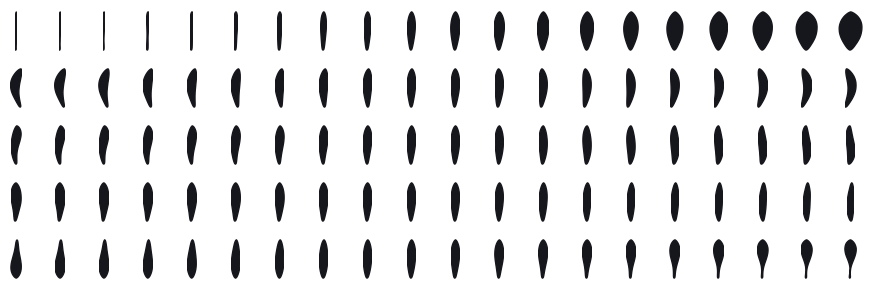

In [88]:
counter = 1
plt.figure(figsize=(9,3))

for m in range(PC_comps):
    for n in range(int):
        plt.subplot(PC_comps,int,counter)
        plt.fill(eigenlf[m,n,:,0], eigenlf[m,n,:,1], c="#16161d")
        plt.gca().set_aspect("equal")
        counter+=1
        plt.axis("off")
plt.tight_layout()

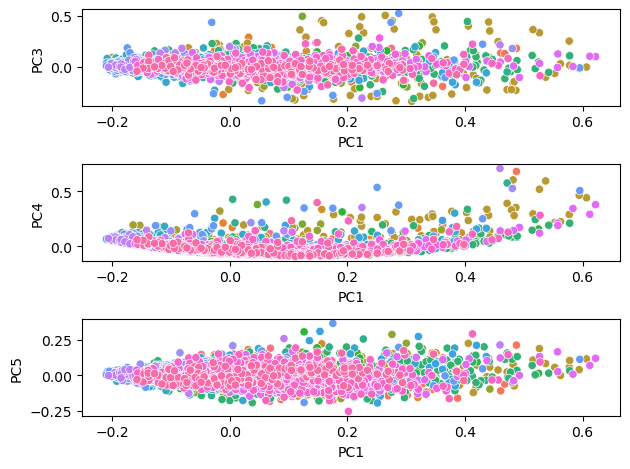

In [89]:
plt.subplot(3,1,1)
sns.scatterplot(mdata, x="PC1", y="PC3", hue="species", legend=False)

plt.subplot(3,1,2)
sns.scatterplot(mdata, x="PC1", y="PC4", hue="species", legend=False)

plt.subplot(3,1,3)
sns.scatterplot(mdata, x="PC1", y="PC5", hue="species", legend=False)

plt.tight_layout()

<Axes: xlabel='PC5', ylabel='Count'>

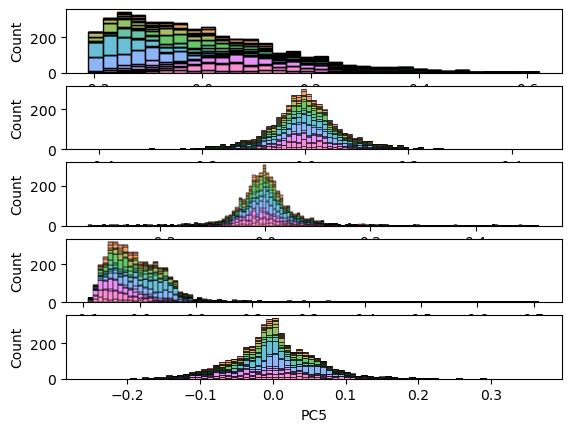

In [90]:
plt.subplot(5,1,1)
sns.histplot(mdata, x="PC1",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,2)
sns.histplot(mdata, x="PC2",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,3)
sns.histplot(mdata, x="PC3",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,4)
sns.histplot(mdata, x="PC4",hue="species", multiple="stack", legend=False)

plt.subplot(5,1,5)
sns.histplot(mdata, x="PC5",hue="species", multiple="stack", legend=False)

Save PCA and PC vals for 3D light modeling

In [23]:
######
PC_comps = 10 
#######

pca = PCA(n_components=PC_comps) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

import pickle
with open("lobelia_pca.pkl", "wb") as file:
    pickle.dump(pca, file)
np.save('lobelia_pc_vals.npy', PCs)


# Linear Discriminant Analysis by species

In [91]:
# get value counts of species
mdata["species"].value_counts()

species
kalmii              544
glandulosa          505
puberula            390
siphilitica         374
elongata            294
flaccidifolia       232
feayana             227
cardinalis          223
spicata             179
appendiculata       179
dortmanna           149
brevifolia          126
apalachicolensis    123
nuttalii            118
inflata              96
paludosa             85
batsonii             79
canbyi               69
rogersii             64
amoena               18
floridana             7
georgiana             3
gattingerii           2
Name: count, dtype: int64

Text(95.72222222222221, 0.5, 'Actual class')

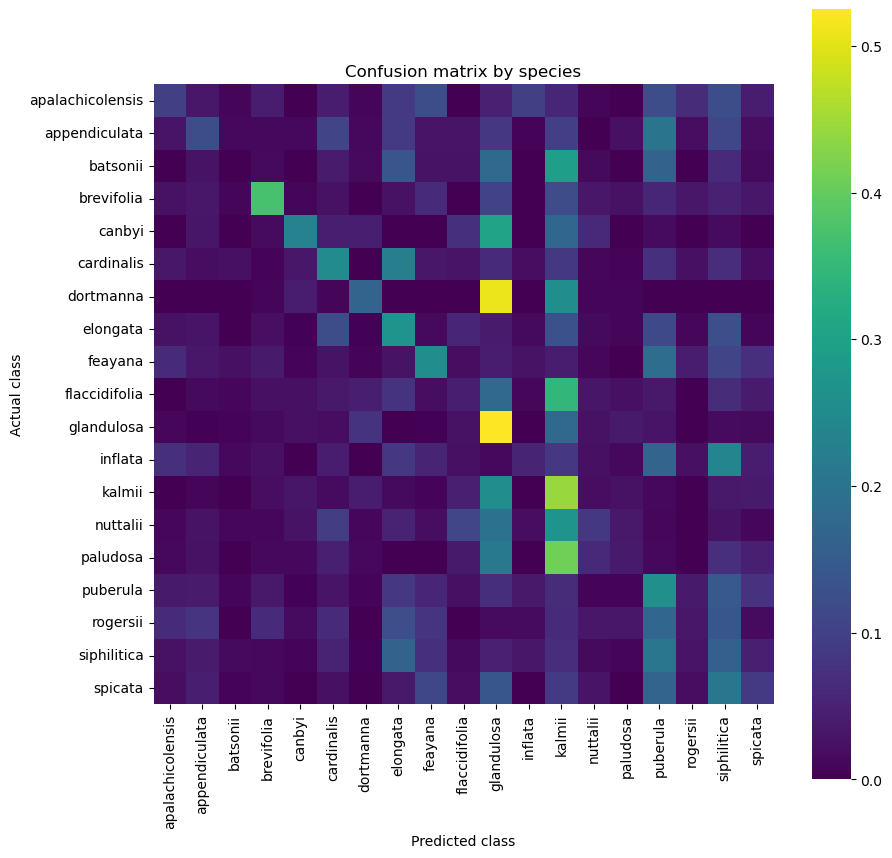

In [92]:
# create a df for LDA by species
species_df = pd.DataFrame(data=flat_arr[:,:])

# List of factor levels to remove
# remove 5 or lower samples, for K fold stratified sampling of 5
levels_to_remove = []
for i in range(len(spes)):
    if spe_counts[i]<thresh: # if under threshold number of samples, add to species to exclude
        levels_to_remove.append(spes[i])

# list of indices to remove
indices_to_remove = mdata[mdata['species'].isin(levels_to_remove)].index.tolist()

# remove indices from procrustes coordinates
# create input and output variables
X = species_df.iloc[:,0:((res*2)-1)*2]
X = X.drop(indices_to_remove).reset_index(drop=True)
y = mdata["species"].drop(indices_to_remove).reset_index(drop=True)

# fit the LDA model
species_model = LinearDiscriminantAnalysis()

# create a StratifiedKFold object with k=5
skf = StratifiedKFold(n_splits=5)

# initialize an empty confusion matrix
cm = np.zeros( ( len(np.unique(y)), len(np.unique(y))  ))

# perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the LDA model on the training data
    species_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = species_model.predict(X_test)

    # Update the confusion matrix
    cm += confusion_matrix(y_test, y_pred)

row_sums = cm.sum(axis=1, keepdims=True)
cm = cm / row_sums

classes = np.sort(y.unique())

# Confusion matrix

plt.figure(figsize=(10,10))

sns.heatmap(cm, 
            #annot=False, 
            #annot_kws={"fontsize":8}, 
            #fmt="{0:f}", 
            cmap="viridis", 
            square=True, 
            cbar=True,
            xticklabels=classes,
            yticklabels=classes,
            #norm=LogNorm()
           )
plt.title("Confusion matrix by species")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")

In [93]:
# Create a dataframe to cluster the confusion matrix
cm_df = pd.DataFrame(cm, columns=classes)
cm_df.index = classes

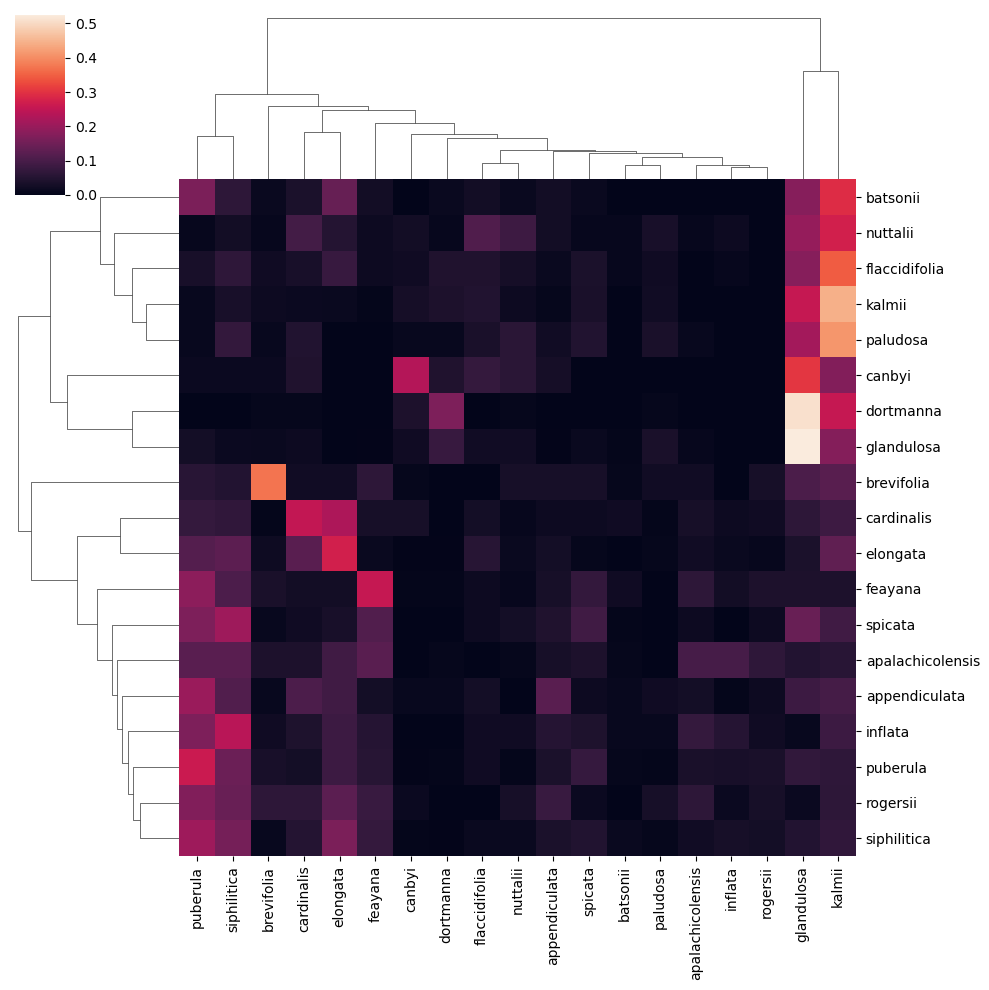

In [97]:
sns.clustermap(cm_df, row_cluster=True, col_cluster=True)

Text(0.5, 1.0, 'Linear Discriminants by species')

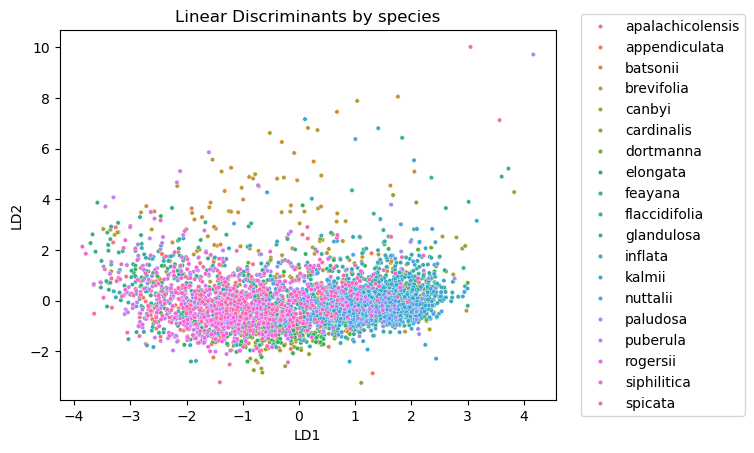

In [98]:
# Plot of linear discriminant scores by genotype

data_plot = species_model.fit(X, y).transform(X)
species_plot_df = pd.DataFrame(data=data_plot[:,:])
species_plot_df["species"] = mdata["species"]
species_plot_df = species_plot_df.drop(indices_to_remove).reset_index(drop=True)

species_plot_df = species_plot_df.rename(columns={0:'LD1', 1:'LD2', 2:"LD3", 3:"LD4", 4:"LD5", 5:"LD6"})

sns.scatterplot(data=species_plot_df, x="LD1", y="LD2", hue="species", s=10)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

plt.title("Linear Discriminants by species")



In [101]:
groupA = ["batsonii","nuttalii","flaccidifolia","kalmii","paludosa"]
groupB = ["canbyi","dortmanna","glandulosa"]
groupC = ["brevifolia"]
groupD = ["cardinalis","elongata"]
groupE = ["feayana","spicata","apalachicolensis","appendiculata","inflata","puberula","rogersii","siphilitica"]

In [102]:
morphotype = []

for i in range(len(species_plot_df)):
    curr_spe = species_plot_df["species"].iloc[i]
    if curr_spe in groupA:
        morphotype.append("A")
    elif curr_spe in groupB:
        morphotype.append("B")
    elif curr_spe in groupC:
        morphotype.append("C")
    elif curr_spe in groupD:
        morphotype.append("D")
    elif curr_spe in groupE:
        morphotype.append("E")

species_plot_df["morphotype"] = morphotype

Text(0.5, 1.0, 'Linear Discriminants by species')

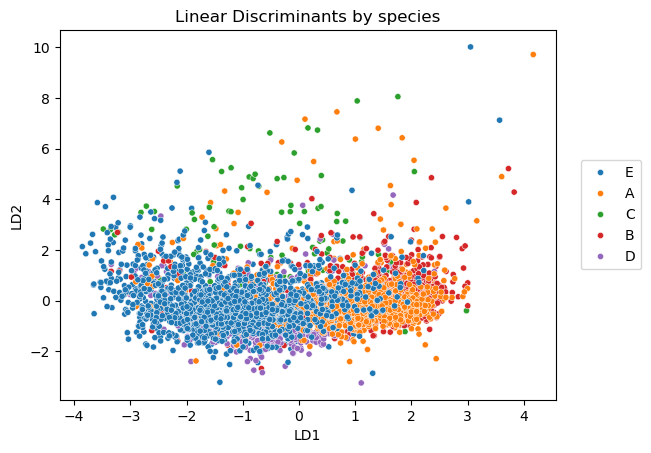

In [103]:
sns.scatterplot(data=species_plot_df, x="LD1", y="LD2", hue="morphotype", s=20)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

plt.title("Linear Discriminants by species")

In [104]:
groupA = ["batsonii","nuttalii","flaccidifolia","kalmii","paludosa"]
groupB = ["canbyi","dortmanna","glandulosa"]
groupC = ["brevifolia"]
groupD = ["cardinalis","elongata"]
groupE = ["feayana","spicata","apalachicolensis","appendiculata","inflata","puberula","rogersii","siphilitica"]


species_list = [
    "batsonii","nuttalii","flaccidifolia","kalmii","paludosa",
    "canbyi","dortmanna","glandulosa",
    "brevifolia",
    "cardinalis","elongata",
    "feayana","spicata","apalachicolensis","appendiculata","inflata","puberula","rogersii","siphilitica"
]

color_list = [
    "orange","orange","orange","orange","orange",
    "red","red","red",
    "green",
    "purple","purple",
    "dodgerblue","dodgerblue","dodgerblue","dodgerblue","dodgerblue","dodgerblue","dodgerblue","dodgerblue",
]
    


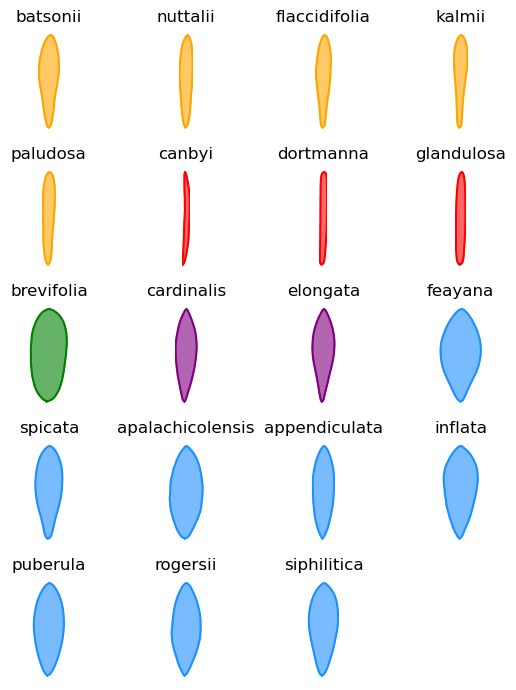

In [105]:
plt.figure(figsize=(6,7))

count = 1

for i in range(len(species_list)):

    curr_spe = species_list[i]
    inds = mdata[mdata["species"]==curr_spe].index
    curr_proc = proc_arr[inds,:,:]
    mean_shape = np.mean(curr_proc, axis=0)

    plt.subplot(5,4,count)
    plt.plot(mean_shape[:,0], mean_shape[:,1], c=color_list[i])
    plt.fill(mean_shape[:,0], mean_shape[:,1], c=color_list[i], alpha=0.6)
    plt.gca().set_aspect("equal")
    plt.title(curr_spe)
    plt.axis("off")

    count+=1

plt.tight_layout()

# Statistical differences in Procrustes distance values

In [ ]:
# get all cultivar names
cult_names = mdata["species"].unique()

# get all pairwise combinations of cultivar names
combinations = list(itertools.combinations(cult_names, 2))

group1_names = [] # a list to store group1 names
group2_names = [] # a list to store group2 names
p_vals = [] # a list to store pvals

for i in range(len(combinations)): # for each combination

    group1 = combinations[i][0] # get the first group name
    group2 = combinations[i][1] # get the second group name
    
    # get the Procrustean coordinates from each group
    group1_lfs = proc_arr[np.array(mdata[mdata["species"]==group1].index)]
    group2_lfs = proc_arr[np.array(mdata[mdata["species"]==group2].index)]
    all_lfs = proc_arr[np.array(mdata[(mdata["species"]==group1) | (mdata["species"]==group2)].index)]
    
    # calculate mean leaf for each group
    group1_mean = np.mean(group1_lfs, axis=0)
    group2_mean = np.mean(group2_lfs, axis=0)
    all_mean = np.mean(all_lfs, axis=0)
    
    # calculate Procrustes distance of each leaf to respective group mean
    group1_dists = []
    for i in range(len(group1_lfs)):
        s1, s2, distance = procrustes(group1_lfs[i,:,:], group1_mean) 
        group1_dists.append(distance)
    
    group2_dists = []
    for i in range(len(group2_lfs)):
        s1, s2, distance = procrustes(group2_lfs[i,:,:], group2_mean) 
        group2_dists.append(distance)
    
    # concatenate arrays to group mean 
    group_mean_dists = np.array(group1_dists+group2_dists)
    
    # calculate Procrustes distance of each leaf to overall mean
    all_dists = []
    for i in range(len(all_lfs)):
        s1, s2, distance = procrustes(all_lfs[i,:,:], all_mean) 
        all_dists.append(distance)
    all_dists = np.array(all_dists)

    # calculate p value
    statistic, p_value = stats.kruskal(group_mean_dists, all_dists)

    # store data
    p_vals.append(p_value)
    group1_names.append(group1)
    group2_names.append(group2)

# Adjust p-values using the FDR BH correction
BH_pvals = multitest.multipletests(p_vals, method='fdr_bh', alpha=0.05)

# create a matrix for clustermap
group_df = pd.DataFrame({

    "group1":group1_names,
    "group2":group2_names,
    "significant":BH_pvals[0],
    "BH":BH_pvals[1]
})

inv_group_df = pd.DataFrame({
    "group1":group2_names,
    "group2":group1_names,
    "significant":BH_pvals[0],
    "BH":BH_pvals[1]
})


pairwise_df = pd.concat([group_df, inv_group_df])

matrix = (pairwise_df.pivot(index='group1', columns='group2', values='BH')
   .fillna(1, downcast='infer')
)

g = sns.clustermap(matrix)
ax = g.ax_heatmap
#[ax.axhline(y=i, color='white', linestyle='-') for i in [4,9]]
#[ax.axvline(x=i, color='white', linestyle='-') for i in [4,9]]

In [ ]:
groupA = ["LCANB","LNUTT","LPALU","LKALM","LGLAN","LDORT","LFLAC"]
groupB = ["LCARD","LPUBE","LFEAY","LROGE","LBREV","LELON","LSPIC","LAPPE","LINFL","LSIPH"]
groupC = ["LAMOE","LBATS","LAPAL","LFLOR"]

In [ ]:
species_list = ["LCANB","LNUTT","LPALU","LKALM","LGLAN","LDORT","LFLAC",
"LCARD","LPUBE","LFEAY","LROGE","LBREV","LELON","LSPIC","LAPPE","LINFL","LSIPH",
"LAMOE","LBATS","LAPAL","LFLOR"]

color_list = ["orange","orange","orange","orange","orange","orange","orange",
              "green","green","green","green","green","green","green","green","green","green",
              "dodgerblue","dodgerblue","dodgerblue","dodgerblue",]

In [ ]:
plt.figure(figsize=(6,7))

count = 1

for i in range(len(species_list)):

    curr_spe = species_list[i]
    inds = mdata[mdata["species"]==curr_spe].index
    curr_proc = proc_arr[inds,:,:]
    mean_shape = np.mean(curr_proc, axis=0)

    plt.subplot(5,5,count)
    plt.plot(mean_shape[:,0], mean_shape[:,1], c=color_list[i])
    plt.fill(mean_shape[:,0], mean_shape[:,1], c=color_list[i], alpha=0.6)
    plt.gca().set_aspect("equal")
    plt.title(curr_spe)
    plt.axis("off")

    count+=1

plt.tight_layout()

In [ ]:
groups = []

for i in range(len(mdata)):
    curr_spe = mdata["species"].iloc[i]
    if curr_spe in groupA:
        groups.append("A")
    elif curr_spe in groupB:
        groups.append("B")
    elif curr_spe in groupC:
        groups.append("C")

mdata["group"] = groups

In [ ]:
# get A, B, and C leaf coords from proc_arr using indices from df all_mdata
A_lfs = proc_arr[np.array(mdata[mdata["group"]=="A"].index)]
B_lfs = proc_arr[np.array(mdata[mdata["group"]=="B"].index)]
C_lfs = proc_arr[np.array(mdata[mdata["group"]=="C"].index)]

# create mean leaves for A, B, and C, pairwise, and overall mean
A_mean = np.mean(A_lfs, axis=0)
B_mean = np.mean(B_lfs, axis=0)
C_mean = np.mean(C_lfs, axis=0)

A_B_mean = np.mean(np.row_stack((A_lfs, B_lfs)), axis=0)
A_C_mean = np.mean(np.row_stack((A_lfs, C_lfs)), axis=0)
B_C_mean = np.mean(np.row_stack((B_lfs, C_lfs)), axis=0)

overall_mean = np.mean(proc_arr, axis=0)

# plot our comparison of A, B, and C procrustean leaves and means
plt.figure(figsize=(20,10))

A_col = "orange"
B_col = "green"
C_col = "dodgerblue"

#########################
# A vs B
#########################

plt.subplot(131)
plt.plot(A_mean[:,0],A_mean[:,1], c=A_col, lw=3, label="A")
plt.plot(B_mean[:,0],B_mean[:,1], c=B_col, lw=3, label="B")
plt.legend()

for i in range(len(proc_arr)):

    if mdata["group"].iloc[i]=="A":
        col = A_col
    else:
        col = B_col

    plt.plot(proc_arr[i,:,0],proc_arr[i,:,1], c=col, lw=0.05, alpha=0.8)
    plt.gca().set_aspect("equal")

plt.axis("off")

#########################
# A vs C
#########################

plt.subplot(132)
plt.plot(A_mean[:,0],A_mean[:,1], c=A_col, lw=3, label="A")
plt.plot(C_mean[:,0],C_mean[:,1], c=C_col, lw=3, label="C")
plt.legend()

for i in range(len(proc_arr)):

    if mdata["group"].iloc[i]=="A":
        col = A_col
    else:
        col = C_col

    plt.plot(proc_arr[i,:,0],proc_arr[i,:,1], c=col, lw=0.05, alpha=0.8)
    plt.gca().set_aspect("equal")

plt.axis("off")

#########################
# B vs C
#########################

plt.subplot(133)
plt.plot(B_mean[:,0],B_mean[:,1], c=B_col, lw=3, label="B")
plt.plot(C_mean[:,0],C_mean[:,1], c=C_col, lw=3, label="C")
plt.legend()

for i in range(len(proc_arr)):

    if mdata["group"].iloc[i]=="B":
        col = B_col
    else:
        col = C_col

    plt.plot(proc_arr[i,:,0],proc_arr[i,:,1], c=col, lw=0.05, alpha=0.8)
    plt.gca().set_aspect("equal")

plt.axis("off")

In [ ]:
#########################
#########################
######## A VS B #########
#########################
#########################

A_B_p_vals = [] # store p values for each landmark

for i in range(np.shape(proc_arr)[1]):

    ## GROUP 1##
    # eulidean distances of A sample to A mean
    A_eds = euclid_dist(A_lfs[:,i,0],A_lfs[:,i,1],
                A_mean[i,0],A_mean[i,1])
    # eulidean distances of B sample to B mean
    B_eds = euclid_dist(B_lfs[:,i,0],B_lfs[:,i,1],
                B_mean[i,0],B_mean[i,1])
    # group 1 = euclidean distances to group mean
    group1 = np.concatenate((A_eds, B_eds))

    ## GROUP 2##
    # eulidean distances of A to pairwise mean
    ovr_A_eds = euclid_dist(A_lfs[:,i,0],A_lfs[:,i,1],
                A_B_mean[i,0],A_B_mean[i,1])
    # eulidean distances of B sample to pairwise mean
    ovr_B_eds = euclid_dist(B_lfs[:,i,0],B_lfs[:,i,1],
                A_B_mean[i,0],A_B_mean[i,1])
    # group 2 = euclidean distances to group mean
    group2 = np.concatenate((ovr_A_eds, ovr_B_eds))
    
    # perform Kruskal-Wallis test
    statistic, p_value = stats.kruskal(group1, group2)
    # store p value
    A_B_p_vals.append(p_value)
    
# Adjust p-values using the BH correction
A_B_fdrBH_pvals = multitest.multipletests(A_B_p_vals, method='fdr_bh')

# get -log10 p values
A_B_neg_log10 = -np.log10(A_B_fdrBH_pvals[1])


#########################
#########################
######## A VS C #########
#########################
#########################

A_C_p_vals = [] # store p values for each landmark

for i in range(np.shape(proc_arr)[1]):

    ## GROUP 1##
    # eulidean distances of A sample to A mean
    A_eds = euclid_dist(A_lfs[:,i,0],A_lfs[:,i,1],
                A_mean[i,0],A_mean[i,1])
    # eulidean distances of C sample to C mean
    C_eds = euclid_dist(C_lfs[:,i,0],C_lfs[:,i,1],
                C_mean[i,0],C_mean[i,1])
    # group 1 = euclidean distances to group mean
    group1 = np.concatenate((A_eds, C_eds))

    ## GROUP 2##
    # eulidean distances of A to pairwise mean
    ovr_A_eds = euclid_dist(A_lfs[:,i,0],A_lfs[:,i,1],
                A_C_mean[i,0],A_C_mean[i,1])
    # eulidean distances of C sample to overall mean
    ovr_C_eds = euclid_dist(C_lfs[:,i,0],C_lfs[:,i,1],
                A_C_mean[i,0],A_C_mean[i,1])
    # group 2 = euclidean distances to group mean
    group2 = np.concatenate((ovr_A_eds, ovr_C_eds))
    
    # perform Kruskal-Wallis test
    statistic, p_value = stats.kruskal(group1, group2)
    # store p value
    A_C_p_vals.append(p_value)
    
# Adjust p-values using the BH correction
A_C_fdrBH_pvals = multitest.multipletests(A_C_p_vals, method='fdr_bh')

# get -log10 p values
A_C_neg_log10 = -np.log10(A_C_fdrBH_pvals[1])

#########################
#########################
######## B VS C #########
#########################
#########################

B_C_p_vals = [] # store p values for each landmark

for i in range(np.shape(proc_arr)[1]):

    ## GROUP 1##
    # eulidean distances of A sample to A mean
    B_eds = euclid_dist(B_lfs[:,i,0],B_lfs[:,i,1],
                B_mean[i,0],B_mean[i,1])
    # eulidean distances of C sample to C mean
    C_eds = euclid_dist(C_lfs[:,i,0],C_lfs[:,i,1],
                C_mean[i,0],C_mean[i,1])
    # group 1 = euclidean distances to group mean
    group1 = np.concatenate((B_eds, C_eds))

    ## GROUP 2##
    # eulidean distances of A to overall mean
    ovr_B_eds = euclid_dist(B_lfs[:,i,0],B_lfs[:,i,1],
                B_C_mean[i,0],B_C_mean[i,1])
    # eulidean distances of C sample to overall mean
    ovr_C_eds = euclid_dist(C_lfs[:,i,0],C_lfs[:,i,1],
                B_C_mean[i,0],B_C_mean[i,1])
    # group 2 = euclidean distances to group mean
    group2 = np.concatenate((ovr_B_eds, ovr_C_eds))
    
    # perform Kruskal-Wallis test
    statistic, p_value = stats.kruskal(group1, group2)
    # store p value
    B_C_p_vals.append(p_value)
    
# Adjust p-values using the BH correction
B_C_fdrBH_pvals = multitest.multipletests(B_C_p_vals, method='fdr_bh')

# get -log10 p values
B_C_neg_log10 = -np.log10(B_C_fdrBH_pvals[1])

#######################
#######################
### CREATE PVAL DF  ###
#######################
#######################

# create a pandas dataframe with overall mean leaf coordinates for plotting
pval_df = pd.DataFrame({"xval":overall_mean[:,0],
                        "yval":overall_mean[:,1],
                        "A_B_pval":A_B_neg_log10,
                       "A_C_pval":A_C_neg_log10,
                       "B_C_pval":B_C_neg_log10})


In [ ]:
# Reset -log10 p values to -log10(0.05) if equal to or lower than that value for plotting

pval_df["A_B_pval"] = np.where(pval_df["A_B_pval"]<=-np.log10(0.05), -np.log10(0.05), pval_df["A_B_pval"])
pval_df["A_C_pval"] = np.where(pval_df["A_C_pval"]<=-np.log10(0.05), -np.log10(0.05), pval_df["A_C_pval"])
pval_df["B_C_pval"] = np.where(pval_df["B_C_pval"]<=-np.log10(0.05), -np.log10(0.05), pval_df["B_C_pval"])

In [ ]:
# project negative log10 FDR BH pvals on mean leaf

plt.figure(figsize=(20,10))

plt.subplot(131)
plt.plot(pval_df["xval"],pval_df["yval"], c="k", zorder=0) # plot of mean leaf
ax=sns.scatterplot(data=pval_df, x="xval", y="yval", hue="A_B_pval", palette="viridis", s=100, 
                   hue_norm=plt.Normalize(-np.log10(0.05), np.max(A_B_neg_log10))
                  ) # pvals
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(132)
plt.plot(pval_df["xval"],pval_df["yval"], c="k", zorder=0) # plot of mean leaf
ax=sns.scatterplot(data=pval_df, x="xval", y="yval", hue="A_C_pval", palette="viridis", s=100,
                  hue_norm=plt.Normalize(-np.log10(0.05), np.max(A_B_neg_log10))
                  ) # pvals
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal")
plt.axis("off")

plt.subplot(133)
plt.plot(pval_df["xval"],pval_df["yval"], c="k", zorder=0) # plot of mean leaf
ax=sns.scatterplot(data=pval_df, x="xval", y="yval", hue="B_C_pval", palette="viridis", s=100,
                  hue_norm=plt.Normalize(-np.log10(0.05), np.max(A_B_neg_log10))
                  ) # pvals
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal")
plt.axis("off")


# Node information

In [ ]:
sns.scatterplot(mdata, x="PC1", y="rel_node", hue="rel_node", s=10, palette="inferno")

In [ ]:
sns.scatterplot(mdata, x="PC2", y="rel_node", hue="rel_node", s=10, palette="inferno")

In [ ]:
sns.scatterplot(mdata, x="PC3", y="rel_node", hue="rel_node", s=10, palette="inferno")

In [ ]:
sns.scatterplot(mdata, x="PC4", y="rel_node", hue="rel_node", s=10, palette="inferno")

In [ ]:
sns.scatterplot(mdata, x="PC5", y="rel_node", hue="rel_node", s=10, palette="inferno")